# AutoML with Text data - Customize Search Space and HPO

This tutorial teaches you how to control the hyperparameter tuning process in `TextPrediction` by specifying:

- A custom search space of candidate hyperparameter values to consider.
- Which hyperparameter optimization algorithm should be used to actually search through this space.

In [1]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')
np.random.seed(123)

## Paraphrasing Identification

We consider a Paraphrase Identification task for illustration. Given a pair of sentences, the goal is to predict whether or not one sentence is a restatement of the other (a binary classification task). Here we train models on the [Microsoft Research Paraphrase Corpus](https://www.microsoft.com/en-us/download/details.aspx?id=52398) dataset.

In [2]:
from autogluon.utils.tabular.utils.loaders import load_pd

train_data = load_pd.load('https://autogluon-text.s3-accelerate.amazonaws.com/glue/mrpc/train.parquet')
dev_data = load_pd.load('https://autogluon-text.s3-accelerate.amazonaws.com/glue/mrpc/dev.parquet')
train_data.head(10)

Loaded data from: https://autogluon-text.s3-accelerate.amazonaws.com/glue/mrpc/train.parquet | Columns = 3 / 3 | Rows = 3668 -> 3668
Loaded data from: https://autogluon-text.s3-accelerate.amazonaws.com/glue/mrpc/dev.parquet | Columns = 3 / 3 | Rows = 408 -> 408


,sentence1,sentence2,label
0,"Amrozi accused his brother , whom he called "" ...","Referring to him as only "" the witness "" , Amr...",1
1,Yucaipa owned Dominick 's before selling the c...,Yucaipa bought Dominick 's in 1995 for $ 693 m...,0
2,They had published an advertisement on the Int...,"On June 10 , the ship 's owners had published ...",1
3,"Around 0335 GMT , Tab shares were up 19 cents ...","Tab shares jumped 20 cents , or 4.6 % , to set...",0
4,"The stock rose $ 2.11 , or about 11 percent , ...",PG & E Corp. shares jumped $ 1.63 or 8 percent...,1
5,Revenue in the first quarter of the year dropp...,With the scandal hanging over Stewart 's compa...,1
6,"The Nasdaq had a weekly gain of 17.27 , or 1.2...",The tech-laced Nasdaq Composite .IXIC rallied ...,0
7,The DVD-CCA then appealed to the state Supreme...,The DVD CCA appealed that decision to the U.S....,1
8,"That compared with $ 35.18 million , or 24 cen...",Earnings were affected by a non-recurring $ 8 ...,0
9,"Shares of Genentech , a much larger company wi...",Shares of Xoma fell 16 percent in early trade ...,0


In [3]:
from autogluon_contrib_nlp.data.tokenizers import MosesTokenizer
tokenizer = MosesTokenizer('en')
print('Paraphrase:')
print('Sentence1: ', tokenizer.decode(train_data['sentence1'][2].split()))
print('Sentence2: ', tokenizer.decode(train_data['sentence2'][2].split()))
print('Label: ', train_data['label'][2])

print('\nNot Paraphrase:')
print('Sentence1:', tokenizer.decode(train_data['sentence1'][3].split()))
print('Sentence2:', tokenizer.decode(train_data['sentence2'][3].split()))
print('Label:', train_data['label'][3])

Paraphrase:
Sentence1:  They had published an advertisement on the Internet on June 10, offering the cargo for sale, he added.
Sentence2:  On June 10, the ship's owners had published an advertisement on the Internet, offering the explosives for sale.
Label:  1

Not Paraphrase:
Sentence1: Around 0335 GMT, Tab shares were up 19 cents, or 4.4%, at A $4.56, having earlier set a record high of A $4.57.
Sentence2: Tab shares jumped 20 cents, or 4.6%, to set a record closing high at A $4.57.
Label: 0


## Explore a Custoimzed Search Space with Random Search

To control which hyperparameter values are considered during `fit()`, we specify the `hyperparameters` argument. Rather than specifying a particular fixed value for a hyperparameter, we can specify a space of values to search over via `ag.space`. We can also specify which HPO algorithm to use for the search via `search_strategy` (a simple [random search](https://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf) is specified below).

In this example, we search for good values of the following [hyperparameters](https://d2l.ai/chapter_natural-language-processing-applications/finetuning-bert.html):

- warmup 
- learning rate 
- dropout before the first task-specific layer 
- layer-wise learning rate decay 
- number of task-specific layers

In [4]:
import autogluon as ag
from autogluon import TextPrediction as task

hyperparameters = {
    'models': {
            'BertForTextPredictionBasic': {
                'search_space': {
                    'model.network.agg_net.num_layers': ag.space.Int(0, 3),
                    'model.network.agg_net.data_dropout': ag.space.Categorical(False, True),
                    'optimization.num_train_epochs': 4,
                    'optimization.warmup_portion': ag.space.Real(0.1, 0.2),
                    'optimization.layerwise_lr_decay': ag.space.Real(0.8, 1.0),
                    'optimization.lr': ag.space.Real(1E-5, 1E-4)
                }
            },
    },
    'hpo_params': {
        'scheduler': 'fifo',
        'search_strategy': 'random'
    }
}

We can now call `fit()` with hyperparameter-tuning over our custom search space. Below `num_trials` controls the maximal number of different hyperparameter configurations for which AutoGluon will train models (5 models are trained under different hyperparameter configurations in this case). To achieve good performance in your applications, you should use larger values of `num_trials`, which may identify superior hyperparameter values but will require longer runtimes.

2020-08-05 09:56:59,315 - root - INFO - All Logs will be saved to ./ag_mrpc_random_search/ag_text_prediction.log
2020-08-05 09:56:59,331 - root - INFO - Train Dataset:
2020-08-05 09:56:59,332 - root - INFO - Columns:

- Text(
   name="sentence1"
   #total/missing=3117/0
   length, min/avg/max=38/118.15/226
)
- Text(
   name="sentence2"
   #total/missing=3117/0
   length, min/avg/max=42/118.32/215
)
- Categorical(
   name="label"
   #total/missing=3117/0
   num_class (total/non_special)=2/2
   categories=[0, 1]
   freq=[995, 2122]
)


2020-08-05 09:56:59,332 - root - INFO - Tuning Dataset:
2020-08-05 09:56:59,333 - root - INFO - Columns:

- Text(
   name="sentence1"
   #total/missing=551/0
   length, min/avg/max=46/120.33/219
)
- Text(
   name="sentence2"
   #total/missing=551/0
   length, min/avg/max=47/121.29/210
)
- Categorical(
   name="label"
   #total/missing=551/0
   num_class (total/non_special)=2/2
   categories=[0, 1]
   freq=[199, 352]
)


2020-08-05 09:56:59,333 - root - INF

 66%|██████▋   | 258/388 [00:46<00:15,  8.35it/s]

 36%|███▌      | 139/388 [00:25<00:46,  5.35it/s]


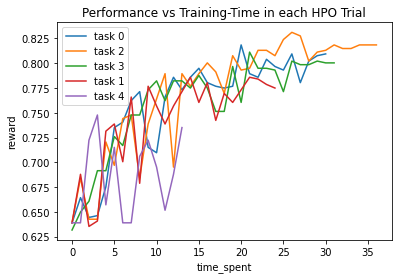

In [5]:
predictor_mrpc = task.fit(train_data,
                          label='label',
                          hyperparameters=hyperparameters,
                          num_trials=5,
                          time_limits=60 * 5,
                          ngpus_per_trial=1,
                          seed=123,
                          output_directory='./ag_mrpc_random_search')

In [6]:
dev_score = predictor_mrpc.evaluate(dev_data, metrics=['acc', 'f1'])
print('Best Config = {}'.format(predictor_mrpc.results['best_config']))
print('Total Time = {}s'.format(predictor_mrpc.results['total_time']))
print('Accuracy = {:.2f}%'.format(dev_score['acc'] * 100))
print('F1 = {:.2f}%'.format(dev_score['f1'] * 100))

Best Config = {'search_space▁model.network.agg_net.data_dropout▁choice': 1, 'search_space▁model.network.agg_net.num_layers': 2, 'search_space▁optimization.layerwise_lr_decay': 0.912355300099337, 'search_space▁optimization.lr': 7.14729072876085e-05, 'search_space▁optimization.warmup_portion': 0.19366799436501417}
Total Time = 85.30689072608948s
Accuracy = 82.35%
F1 = 87.46%


In [7]:
sentence1 = 'It is simple to solve NLP problems with AutoGluon.'
sentence2 = 'With AutoGluon, it is easy to solve NLP problems.'
sentence3 = 'AutoGluon gives you a very bad user experience for solving NLP problems.'
prediction1 = predictor_mrpc.predict({'sentence1': [sentence1], 'sentence2': [sentence2]})
prediction1_prob = predictor_mrpc.predict_proba({'sentence1': [sentence1], 'sentence2': [sentence2]})
print('A = "{}"'.format(sentence1))
print('B = "{}"'.format(sentence2))
print('Prediction = "{}"'.format(prediction1[0] == 1))
print('Prob = "{}"'.format(prediction1_prob[0]))
print('')
prediction2 = predictor_mrpc.predict({'sentence1': [sentence1], 'sentence2': [sentence3]})
prediction2_prob = predictor_mrpc.predict_proba({'sentence1': [sentence1], 'sentence2': [sentence3]})
print('A = "{}"'.format(sentence1))
print('B = "{}"'.format(sentence3))
print('Prediction = "{}"'.format(prediction2[0] == 1))
print('Prob = "{}"'.format(prediction2_prob[0]))

A = "It is simple to solve NLP problems with AutoGluon."
B = "With AutoGluon, it is easy to solve NLP problems."
Prediction = "True"
Prob = "[0.00157321 0.9984268 ]"

A = "It is simple to solve NLP problems with AutoGluon."
B = "AutoGluon gives you a very bad user experience for solving NLP problems."
Prediction = "False"
Prob = "[0.5942185 0.4057815]"


## Use Bayesian Optimization
Apart from random search, we can utilize [skopt](https://scikit-optimize.github.io/stable/) as the searcher, which performs a type of Bayesian Optimization. Basically, skopt will train a *surrogate model* to approximate the performance of the hyperparameter configurations. Whenever we observed the performance of a new set of hyperparameter, we update our posterior. In the next trial, we will try the configuration that best balances the exploitation and exploration tradeoffs.

In [8]:
hyperparameters['hpo_params'] = {
    'scheduler': 'fifo',
    'search_strategy': 'skopt'
}


2020-08-05 10:03:29,458 - root - INFO - All Logs will be saved to ./ag_mrpc_custom_space_fifo_skopt/ag_text_prediction.log
2020-08-05 10:03:29,473 - root - INFO - Train Dataset:
2020-08-05 10:03:29,474 - root - INFO - Columns:

- Text(
   name="sentence1"
   #total/missing=3117/0
   length, min/avg/max=38/118.52/226
)
- Text(
   name="sentence2"
   #total/missing=3117/0
   length, min/avg/max=42/119.18/215
)
- Categorical(
   name="label"
   #total/missing=3117/0
   num_class (total/non_special)=2/2
   categories=[0, 1]
   freq=[1018, 2099]
)


2020-08-05 10:03:29,474 - root - INFO - Tuning Dataset:
2020-08-05 10:03:29,475 - root - INFO - Columns:

- Text(
   name="sentence1"
   #total/missing=551/0
   length, min/avg/max=38/118.25/204
)
- Text(
   name="sentence2"
   #total/missing=551/0
   length, min/avg/max=46/116.42/208
)
- Categorical(
   name="label"
   #total/missing=551/0
   num_class (total/non_special)=2/2
   categories=[0, 1]
   freq=[176, 375]
)


2020-08-05 10:03:29,475 -

 64%|██████▍   | 249/388 [00:45<00:16,  8.59it/s]

100%|██████████| 388/388 [01:07<00:00,  5.71it/s]


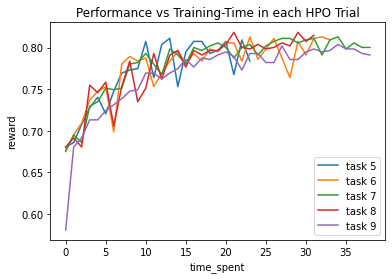

In [9]:
predictor_mrpc_skopt = task.fit(train_data, label='label',
                                hyperparameters=hyperparameters,
                                time_limits=60 * 5,
                                num_trials=5,
                                ngpus_per_trial=1, seed=123,
                                output_directory='./ag_mrpc_custom_space_fifo_skopt')

In [10]:
dev_score = predictor_mrpc_skopt.evaluate(dev_data, metrics=['acc', 'f1'])
print('Best Config = {}'.format(predictor_mrpc_skopt.results['best_config']))
print('Total Time = {}s'.format(predictor_mrpc_skopt.results['total_time']))
print('Accuracy = {:.2f}%'.format(dev_score['acc'] * 100))
print('F1 = {:.2f}%'.format(dev_score['f1'] * 100))

Best Config = {'search_space▁model.network.agg_net.data_dropout▁choice': 1, 'search_space▁model.network.agg_net.num_layers': 1, 'search_space▁optimization.layerwise_lr_decay': 0.8395952073216385, 'search_space▁optimization.lr': 9.718865685254969e-05, 'search_space▁optimization.warmup_portion': 0.19598219802160757}
Total Time = 125.24377870559692s
Accuracy = 83.58%
F1 = 88.55%


In [11]:
predictions = predictor_mrpc_skopt.predict(dev_data)
prediction1 = predictor_mrpc_skopt.predict({'sentence1': [sentence1], 'sentence2': [sentence2]})
prediction1_prob = predictor_mrpc_skopt.predict_proba({'sentence1': [sentence1], 'sentence2': [sentence2]})
print('A = "{}"'.format(sentence1))
print('B = "{}"'.format(sentence2))
print('Prediction = "{}"'.format(prediction1[0] == 1))
print('Prob = "{}"'.format(prediction1_prob[0]))
print('')
prediction2 = predictor_mrpc_skopt.predict({'sentence1': [sentence1], 'sentence2': [sentence3]})
prediction2_prob = predictor_mrpc_skopt.predict_proba({'sentence1': [sentence1], 'sentence2': [sentence3]})
print('A = "{}"'.format(sentence1))
print('B = "{}"'.format(sentence3))
print('Prediction = "{}"'.format(prediction2[0] == 1))
print('Prob = "{}"'.format(prediction2_prob[0]))

A = "It is simple to solve NLP problems with AutoGluon."
B = "With AutoGluon, it is easy to solve NLP problems."
Prediction = "True"
Prob = "[0.00233506 0.9976649 ]"

A = "It is simple to solve NLP problems with AutoGluon."
B = "AutoGluon gives you a very bad user experience for solving NLP problems."
Prediction = "False"
Prob = "[0.82516044 0.17483962]"


## Use Hyperband
We can also use the [Hyperband algorithm](https://arxiv.org/pdf/1603.06560.pdf). Hyperband tackles the HPO with ideas from multi-armed bandit. Basically, hyperband will try multiple configuration simultaneously. It will early stop the bad-performing configuration and only keep training the promising ones. We will not touch details in this presentation.

In [17]:
hyperparameters['hpo_params'] = {
    'scheduler': 'hyperband',
    'search_strategy': 'random',
    'max_t': 40,
}

2020-08-05 10:21:36,402 - root - INFO - All Logs will be saved to ./ag_mrpc_custom_space_hyperband/ag_text_prediction.log
2020-08-05 10:21:36,418 - root - INFO - Train Dataset:
2020-08-05 10:21:36,419 - root - INFO - Columns:

- Text(
   name="sentence1"
   #total/missing=3117/0
   length, min/avg/max=38/118.33/226
)
- Text(
   name="sentence2"
   #total/missing=3117/0
   length, min/avg/max=42/118.70/215
)
- Categorical(
   name="label"
   #total/missing=3117/0
   num_class (total/non_special)=2/2
   categories=[0, 1]
   freq=[1034, 2083]
)


2020-08-05 10:21:36,419 - root - INFO - Tuning Dataset:
2020-08-05 10:21:36,420 - root - INFO - Columns:

- Text(
   name="sentence1"
   #total/missing=551/0
   length, min/avg/max=38/119.32/212
)
- Text(
   name="sentence2"
   #total/missing=551/0
   length, min/avg/max=46/119.17/208
)
- Categorical(
   name="label"
   #total/missing=551/0
   num_class (total/non_special)=2/2
   categories=[0, 1]
   freq=[160, 391]
)


2020-08-05 10:21:36,420 - 

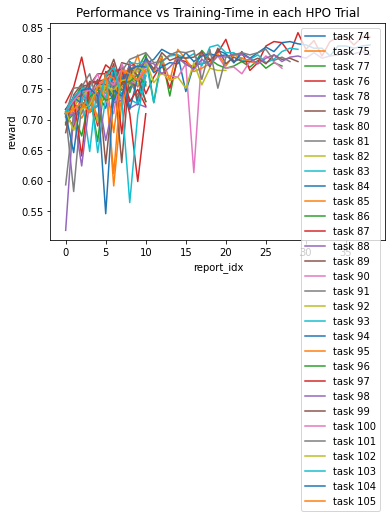

In [20]:
predictor_mrpc_hyperband = task.fit(train_data, label='label',
                                    hyperparameters=hyperparameters,
                                    time_limits=60 * 5, ngpus_per_trial=1, seed=123,
                                    output_directory='./ag_mrpc_custom_space_hyperband')

In [23]:
dev_score = predictor_mrpc_hyperband.evaluate(dev_data, metrics=['acc', 'f1'])
print('Best Config = {}'.format(predictor_mrpc_hyperband.results['best_config']))
print('Total Time = {}s'.format(predictor_mrpc_hyperband.results['total_time']))
print('Accuracy = {:.2f}%'.format(dev_score['acc'] * 100))
print('F1 = {:.2f}%'.format(dev_score['f1'] * 100))

Best Config = {'search_space▁model.network.agg_net.data_dropout▁choice': 1, 'search_space▁model.network.agg_net.num_layers': 2, 'search_space▁optimization.layerwise_lr_decay': 0.912355300099337, 'search_space▁optimization.lr': 7.14729072876085e-05, 'search_space▁optimization.warmup_portion': 0.19366799436501417}
Total Time = 336.5965392589569s
Accuracy = 83.58%
F1 = 88.81%


In [24]:
predictions = predictor_mrpc_hyperband.predict(dev_data)
prediction1 = predictor_mrpc_hyperband.predict({'sentence1': [sentence1], 'sentence2': [sentence2]})
prediction1_prob = predictor_mrpc_hyperband.predict_proba({'sentence1': [sentence1], 'sentence2': [sentence2]})
print('A = "{}"'.format(sentence1))
print('B = "{}"'.format(sentence2))
print('Prediction = "{}"'.format(prediction1[0] == 1))
print('Prob = "{}"'.format(prediction1_prob[0]))
print('')
prediction2 = predictor_mrpc_hyperband.predict({'sentence1': [sentence1], 'sentence2': [sentence3]})
prediction2_prob = predictor_mrpc_hyperband.predict_proba({'sentence1': [sentence1], 'sentence2': [sentence3]})
print('A = "{}"'.format(sentence1))
print('B = "{}"'.format(sentence3))
print('Prediction = "{}"'.format(prediction2[0] == 1))
print('Prob = "{}"'.format(prediction2_prob[0]))

A = "It is simple to solve NLP problems with AutoGluon."
B = "With AutoGluon, it is easy to solve NLP problems."
Prediction = "True"
Prob = "[0.00141819 0.99858177]"

A = "It is simple to solve NLP problems with AutoGluon."
B = "AutoGluon gives you a very bad user experience for solving NLP problems."
Prediction = "False"
Prob = "[0.7991052  0.20089479]"
